# Stock Price Prediction
## Import Libraries
- pip install yfinance
- pip install tensorflow 

In [1]:
import numpy as np
import pandas as pd
import math
import datetime
import yfinance as yf # to use the dataset >> https://pypi.org/project/yfinance/
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (Dense, Dropout, Activation, Flatten, MaxPooling2D, SimpleRNN)
from sklearn.model_selection import train_test_split
plt.rcParams['figure.dpi'] = 300 # runtime configuration 
plt.rcParams['savefig.dpi'] = 300

2023-02-28 21:24:42.899984: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load Data

In [2]:
ticker = ['AAPL', 'MSFT']
start = datetime.datetime(2019, 1, 1)
end = datetime.datetime(2020, 1 ,1)
stock_prices = yf.download(ticker,start=start, end = end, interval='1d').Close
stock_prices

[*********************100%***********************]  2 of 2 completed


,AAPL,MSFT
Date,,
2019-01-02,39.480000,101.120003
2019-01-03,35.547501,97.400002
2019-01-04,37.064999,101.930000
2019-01-07,36.982498,102.059998
2019-01-08,37.687500,102.800003
...,...,...
2019-12-24,71.067497,157.380005
2019-12-26,72.477501,158.669998
2019-12-27,72.449997,158.960007


In [3]:
diff_stock_prices = stock_prices.diff().dropna()
## Differencing can help stabilise the mean of a time series by removing changes in the level of a time series, 
## and therefore eliminating (or reducing) trend and seasonality.
diff_stock_prices

,AAPL,MSFT
Date,,
2019-01-03,-3.932499,-3.720001
2019-01-04,1.517498,4.529999
2019-01-07,-0.082500,0.129997
2019-01-08,0.705002,0.740005
2019-01-09,0.639999,1.469994
...,...,...
2019-12-24,0.067497,-0.029999
2019-12-26,1.410004,1.289993
2019-12-27,-0.027504,0.290009


In [4]:
split = int(len(diff_stock_prices['AAPL'].values) * 0.95)
diff_train_aapl = diff_stock_prices['AAPL'].iloc[:split]
diff_test_aapl = diff_stock_prices['AAPL'].iloc[split:]
diff_train_msft = diff_stock_prices['MSFT'].iloc[:split]
diff_test_msft = diff_stock_prices['MSFT'].iloc[split:]

In [5]:
print(diff_train_aapl.shape)
print(diff_test_aapl.shape)
print(diff_train_msft.shape)
print(diff_test_msft.shape)

(238,)
(13,)
(238,)
(13,)


In [6]:
n_steps = 13 # number of steps for prediction
n_features = 1 # number of features

In [7]:
def split_sequence(sequence, n_steps):
    X, y = [], []
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [8]:
# Calling the split_sequence function to define the lookback period
X_aapl, y_aapl = split_sequence(diff_train_aapl, n_steps)

In [9]:
print(X_aapl.shape)
print(y_aapl.shape)

(225, 13)
(225,)


In [10]:
# just for more explenation
X_aapl2 = pd.DataFrame(X_aapl)
X_aapl2 ["Target (Y)"] = pd.DataFrame(y_aapl)
X_aapl2.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,Target (Y)
0,-3.932499,1.517498,-0.082500,0.705002,0.639999,0.122501,-0.377502,-0.572498,0.767502,0.467499,0.230000,0.240002,-0.880001,0.154999
1,1.517498,-0.082500,0.705002,0.639999,0.122501,-0.377502,-0.572498,0.767502,0.467499,0.230000,0.240002,-0.880001,0.154999,-0.305000
2,-0.082500,0.705002,0.639999,0.122501,-0.377502,-0.572498,0.767502,0.467499,0.230000,0.240002,-0.880001,0.154999,-0.305000,1.264999
3,0.705002,0.639999,0.122501,-0.377502,-0.572498,0.767502,0.467499,0.230000,0.240002,-0.880001,0.154999,-0.305000,1.264999,-0.364998
4,0.639999,0.122501,-0.377502,-0.572498,0.767502,0.467499,0.230000,0.240002,-0.880001,0.154999,-0.305000,1.264999,-0.364998,-0.405003


In [11]:
# Reshaping training data into a three-dimensional case
X_aapl = X_aapl.reshape((X_aapl.shape[0], X_aapl.shape[1], n_features)) #rows, past features, columns 
X_aapl.shape

(225, 13, 1)

In [12]:
X_msft, y_msft = split_sequence(diff_train_msft, n_steps)
X_msft = X_msft.reshape((X_msft.shape[0],  X_msft.shape[1], n_features))

In [13]:
print(X_msft.shape)
print(y_msft.shape)

(225, 13, 1)
(225,)


## First: RNN

### Step#1: Define the Network

In [14]:
model = Sequential() # Calling a sequential model to run the RNN
# SimpleRNN layer
# We use return_sequences with Stacking RNNs, so that the following RNN layers can have the full sequence as input.
model.add(SimpleRNN(512, activation='relu', input_shape=(n_steps, n_features), return_sequences=True))
model.add(Dropout(0.2)) # this layer to avoid overfitting (rate between 0 and 1.)
# A Dense layer feeds all outputs from the previous layer to all its neurons, 
# each neuron providing one output to the next layer.
model.add(Dense(256, activation = 'relu')) 
model.add(Flatten())
model.add(Dense(1, activation='linear'))

2023-02-28 21:32:32.696583: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Step#2: Compile the Model

In [15]:
model.compile(optimizer='rmsprop', # Root Mean Squared Propagation
              loss='mean_squared_error',
              metrics=['mse'])

### Step#3: Fit the Model

In [16]:
# Fitting the RNN model to Apple’s stock price
history = model.fit(X_aapl, y_aapl, epochs=400, batch_size=150, verbose=2, validation_split = 0.10)
# batch size is a hyperparameter defines the number of samples to work through before updating the model parameters.
# verbose=0 will show you nothing (silent)
# verbose=1 will show you an animated progress bar
# verbose=2 will just mention the number of epoch
# validation_split = (0 to 1). Fraction of the training data to be used as validation data. 

Epoch 1/400
2/2 - 1s - loss: 0.6995 - mse: 0.6995 - val_loss: 0.5115 - val_mse: 0.5115 - 923ms/epoch - 461ms/step
Epoch 2/400
2/2 - 0s - loss: 0.6196 - mse: 0.6196 - val_loss: 0.4931 - val_mse: 0.4931 - 77ms/epoch - 38ms/step
Epoch 3/400
2/2 - 0s - loss: 0.5814 - mse: 0.5814 - val_loss: 0.5035 - val_mse: 0.5035 - 73ms/epoch - 37ms/step
Epoch 4/400
2/2 - 0s - loss: 0.5589 - mse: 0.5589 - val_loss: 0.5450 - val_mse: 0.5450 - 74ms/epoch - 37ms/step
Epoch 5/400
2/2 - 0s - loss: 0.5393 - mse: 0.5393 - val_loss: 0.5704 - val_mse: 0.5704 - 84ms/epoch - 42ms/step
Epoch 6/400
2/2 - 0s - loss: 0.5216 - mse: 0.5216 - val_loss: 0.5861 - val_mse: 0.5861 - 83ms/epoch - 42ms/step
Epoch 7/400
2/2 - 0s - loss: 0.5247 - mse: 0.5247 - val_loss: 0.5697 - val_mse: 0.5697 - 80ms/epoch - 40ms/step
Epoch 8/400
2/2 - 0s - loss: 0.4996 - mse: 0.4996 - val_loss: 0.6019 - val_mse: 0.6019 - 81ms/epoch - 40ms/step
Epoch 9/400
2/2 - 0s - loss: 0.4858 - mse: 0.4858 - val_loss: 0.6101 - val_mse: 0.6101 - 81ms/epoch - 

In [17]:
# Defining the starting point of the prediction for Apple
start = X_aapl[X_aapl.shape[0] - n_steps] # X_aapl[212] >> 225-13
x_input = start
x_input = x_input.reshape((1, n_steps, n_features)) # (13, 1) to (1, 13, 1)

In [18]:
print(x_input.shape)
x_input

(1, 13, 1)


array([[[-0.09249878],
        [ 0.02749634],
        [ 0.54750061],
        [ 0.17750549],
        [ 0.51499939],
        [-0.06000519],
        [ 0.62750244],
        [-0.45749664],
        [ 0.77999878],
        [ 0.33499908],
        [-0.20249939],
        [-0.77500153],
        [-0.29499817]]])

In [24]:
tempList_aapl = [] # an empty list to store predictions
for i in range(len(diff_test_aapl)): # 13
    x_input = x_input.reshape((1, n_steps, n_features)) # Reshaping the x_input, which is used for prediction
    #print(x_input)
    #print("****")
    yhat = model.predict(x_input, verbose=0) # Running prediction for Apple stock
    #print(yhat)
    #print("****")
    x_input = np.append(x_input, yhat) # Storing yhat into tempList_aapl
    #print(x_input)
    #print("****")
    x_input = x_input[1:] # update x_input to start with the second value in x_input
    #print(x_input)
    #print("****")
    tempList_aapl.append(yhat)
    #print("--------------------------------")

In [25]:
tempList_aapl

[array([[0.5462029]], dtype=float32),
 array([[0.83981776]], dtype=float32),
 array([[0.2959042]], dtype=float32),
 array([[-0.25536242]], dtype=float32),
 array([[0.28680992]], dtype=float32),
 array([[-1.2944981]], dtype=float32),
 array([[0.47104272]], dtype=float32),
 array([[0.6414062]], dtype=float32),
 array([[0.13071236]], dtype=float32),
 array([[0.0508579]], dtype=float32),
 array([[0.03862747]], dtype=float32),
 array([[0.1252913]], dtype=float32),
 array([[-0.00128838]], dtype=float32)]

In [26]:
history = model.fit(X_msft, y_msft, epochs=400, batch_size=150, verbose=0, validation_split = 0.10)

In [27]:
start = X_msft[X_msft.shape[0] - n_steps]
x_input = start
x_input = x_input.reshape((1, n_steps, n_features))

In [28]:
tempList_msft = []
for i in range(len(diff_test_msft)):
    x_input = x_input.reshape((1, n_steps, n_features))
    yhat = model.predict(x_input, verbose=0)
    x_input = np.append(x_input, yhat)
    x_input = x_input[1:]
    tempList_msft.append(yhat)

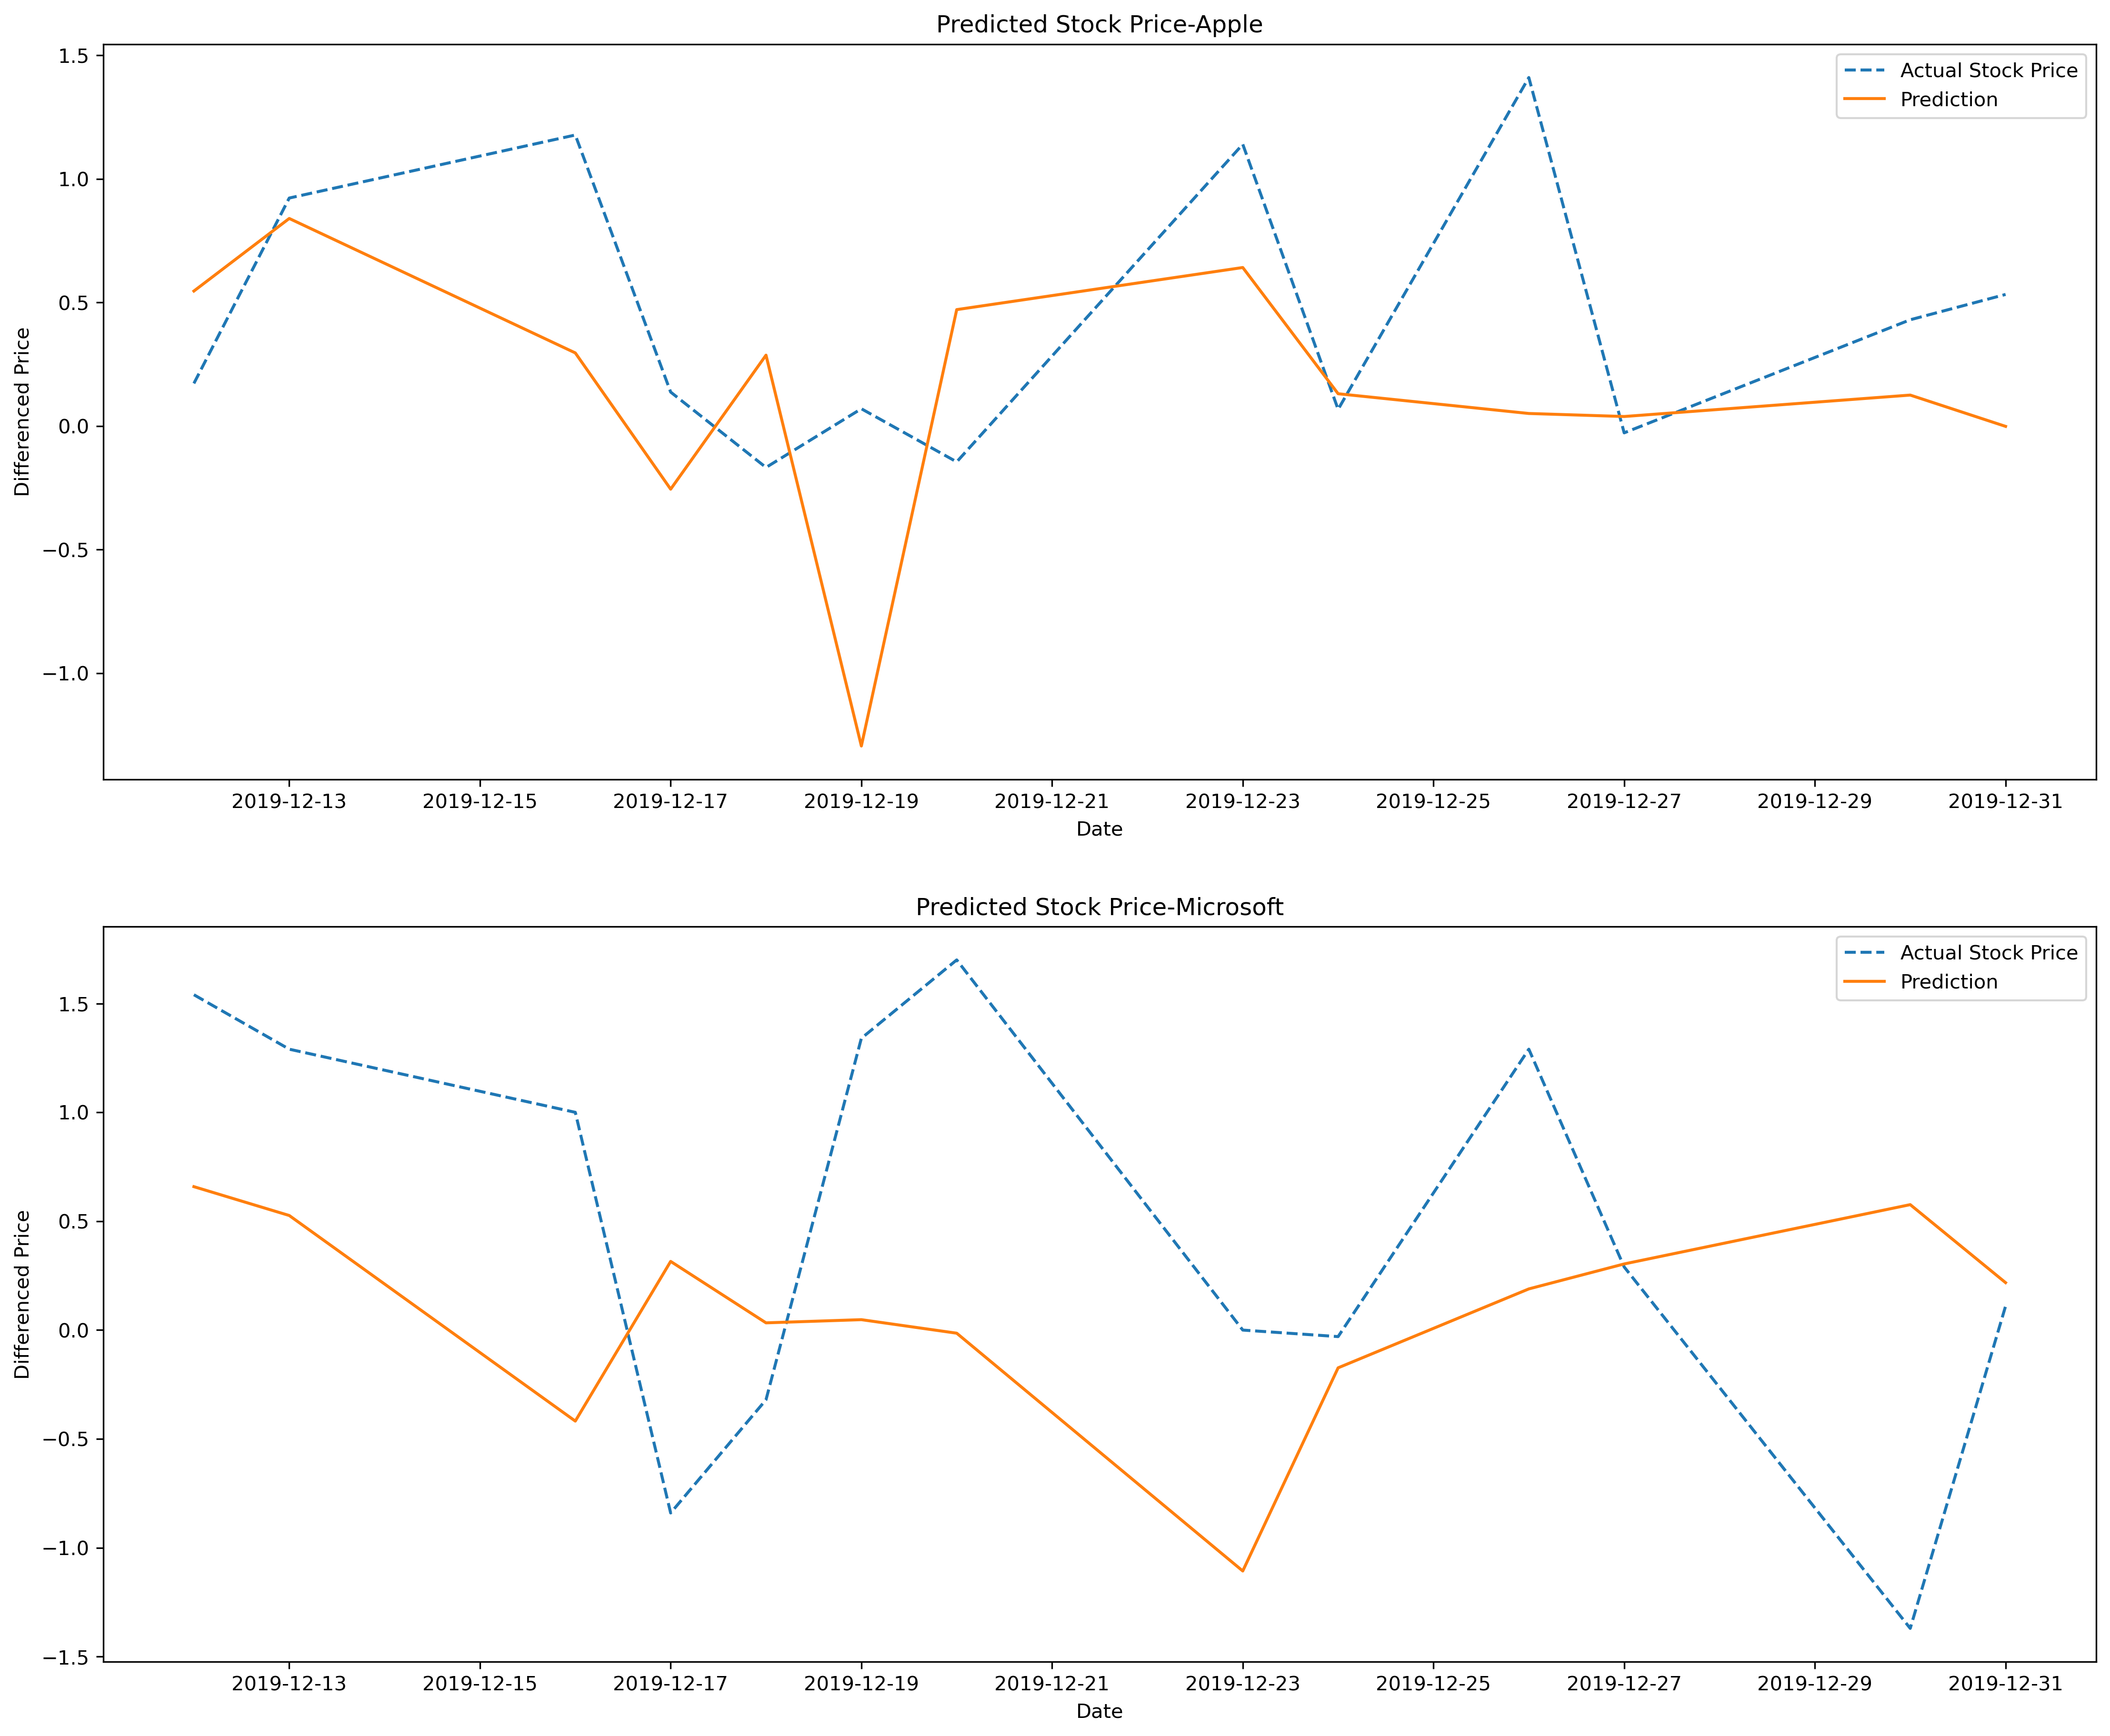

In [29]:
#  visualization
fig, ax = plt.subplots(2,1, figsize=(18,15))
ax[0].plot(diff_test_aapl, label='Actual Stock Price', linestyle='--')
ax[0].plot(diff_test_aapl.index, np.array(tempList_aapl).flatten(), linestyle='solid', label="Prediction")
ax[0].set_title('Predicted Stock Price-Apple')
ax[0].legend(loc='best')

ax[1].plot(diff_test_msft, label='Actual Stock Price', linestyle='--')
ax[1].plot(diff_test_msft.index,np.array(tempList_msft).flatten(), linestyle='solid', label="Prediction")
ax[1].set_title('Predicted Stock Price-Microsoft')
ax[1].legend(loc='best')


for ax in ax.flat:
    ax.set(xlabel='Date', ylabel='Differenced Price')
plt.show()

## Second: LSTM

In [30]:
from tensorflow.keras.layers import LSTM

In [31]:
n_steps = 13
n_features = 1
model = Sequential()
model.add(LSTM(512, activation='relu', input_shape=(n_steps, n_features),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256,activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='linear'))

In [32]:
model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['mse'])
history = model.fit(X_aapl, y_aapl, epochs=400, batch_size=150, verbose=0, validation_split = 0.10)

In [33]:
start = X_aapl[X_aapl.shape[0] - 13]
x_input = start
x_input = x_input.reshape((1, n_steps, n_features))

In [34]:
tempList_aapl = []
for i in range(len(diff_test_aapl)):
    x_input = x_input.reshape((1, n_steps, n_features))
    yhat = model.predict(x_input, verbose=0)
    x_input = np.append(x_input, yhat)
    x_input = x_input[1:]
    tempList_aapl.append(yhat)

In [35]:
history = model.fit(X_msft, y_msft, epochs=400, batch_size=150, verbose=0, validation_split = 0.10)

In [36]:
start = X_msft[X_msft.shape[0] - 13]
x_input = start
x_input = x_input.reshape((1, n_steps, n_features))

In [37]:
tempList_msft = []
for i in range(len(diff_test_msft)):
    x_input = x_input.reshape((1, n_steps, n_features))
    yhat = model.predict(x_input, verbose=0)
    x_input = np.append(x_input, yhat)
    x_input = x_input[1:]
    tempList_msft.append(yhat)

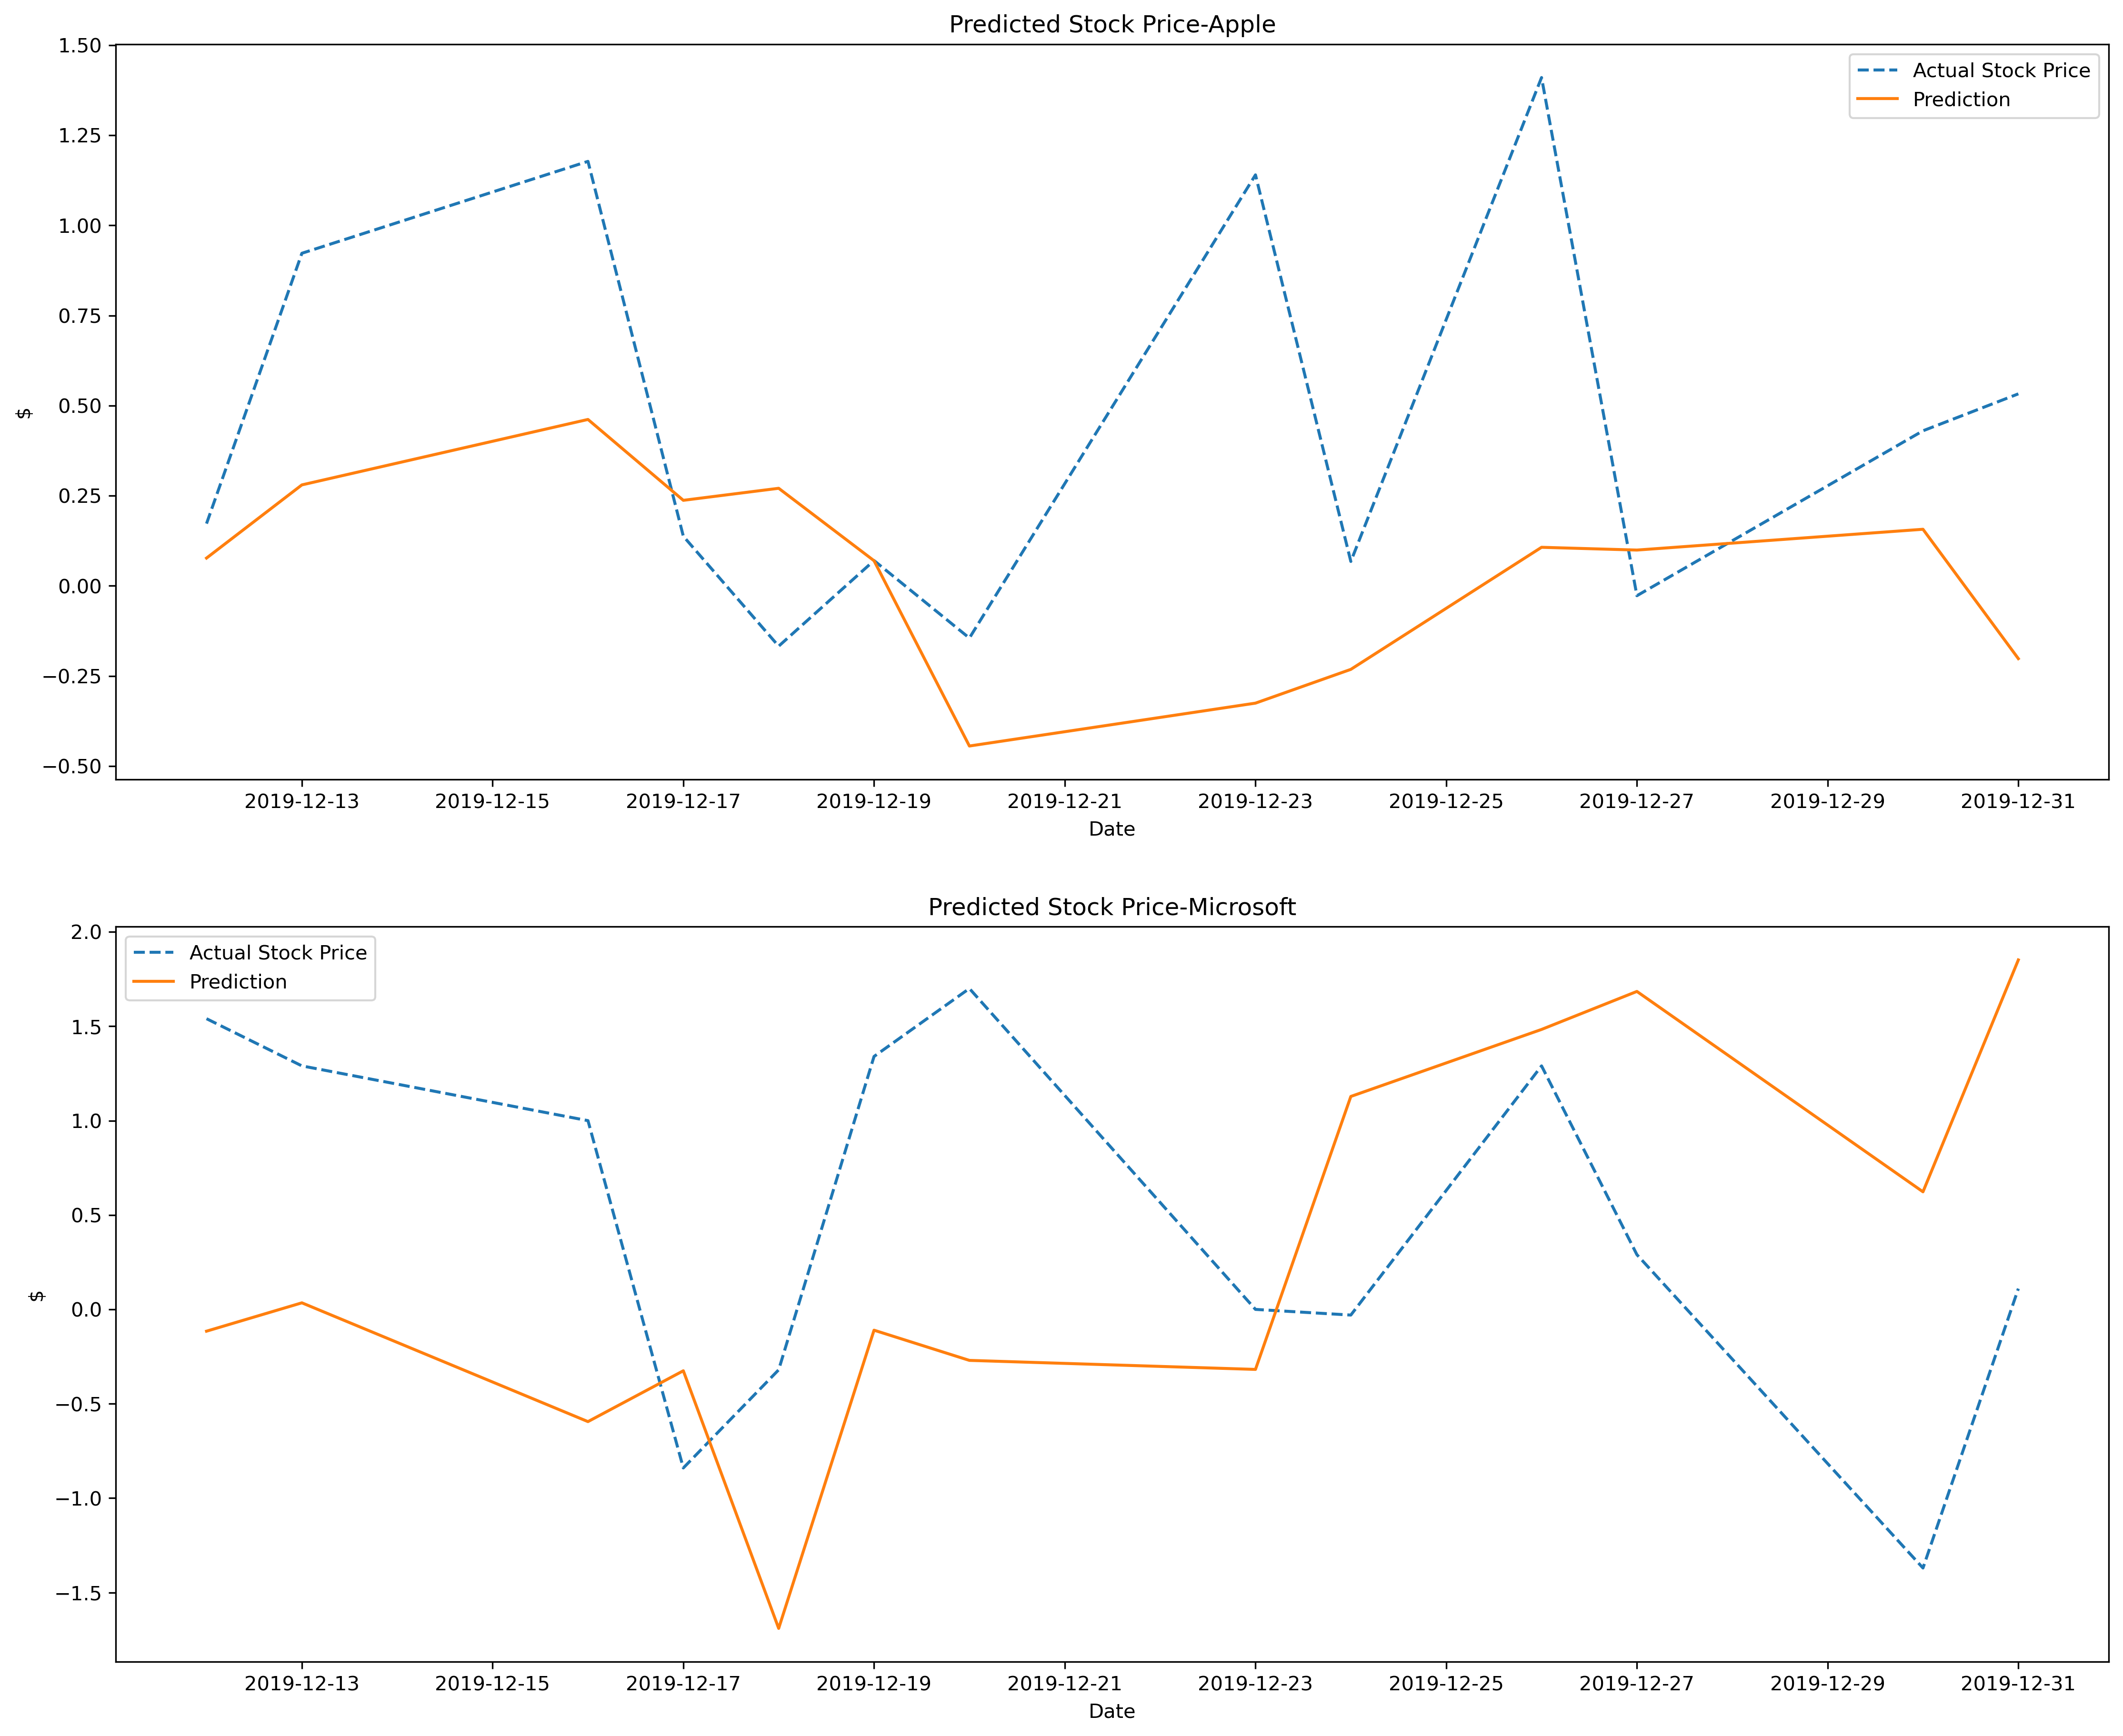

In [38]:
fig, ax = plt.subplots(2, 1, figsize=(18, 15))
ax[0].plot(diff_test_aapl, label='Actual Stock Price', linestyle='--')
ax[0].plot(diff_test_aapl.index, np.array(tempList_aapl).flatten(), linestyle='solid', label="Prediction")
ax[0].set_title('Predicted Stock Price-Apple')
ax[0].legend(loc='best')
ax[1].plot(diff_test_msft, label='Actual Stock Price', linestyle='--')
ax[1].plot(diff_test_msft.index, np.array(tempList_msft).flatten(), linestyle='solid', label="Prediction")
ax[1].set_title('Predicted Stock Price-Microsoft')
ax[1].legend(loc='best')

for ax in ax.flat:
    ax.set(xlabel='Date', ylabel='$')
plt.show()